<a href="https://colab.research.google.com/github/mikelmiras/mdd/blob/main/Cats_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejericio 2: Clasificando Gatos con Regresión Logística
En el ejercicio anterior cargamos los datos de unos ficheros con imágenes de gatos. En este segundo ejercicio, aprenderemos un modelo muy simple de regresión logística. Recuerda que ese modelo se puede considerar una versión muy simple de una red neuronal. A continuación, el diagrama que describe el modelo que vamos a implementar:

![alt text](https://drive.google.com/uc?id=1VfKgnsvczXqKMMMGz_GR8reLQUIX7kDS)



La expresión matemática del algoritmo

Para una muestra de datos $x^{(i)}$:

$z^{(i)} = W^T x^{(i)} + b$

$\hat{y} = a^{(i)} = \sigma (z^{(i)})$

$(a^{(i)}, y^{(i)}) = - y^{(i)} log(a^{(i)} - (1-y^{(i)}) log(1-a^{(i)})$

La función de coste se consigue calculando sobre todas las muestras de train:

$J = \frac{1}{m} \Sigma_{i=1}^m (a^{(i)}, y^{(i)})$


Estas son las tareas principales a realizar en este ejercicio:


*   Inicializar los parámetros del modelo.
*   Aprender los parámetros óptimos del modelo minimizando la función de coste.
*   Clasificar las muestras de test con los parámetros aprendidos.
*   Analizar los resultados y extraer conclusiones.

# Preparación del entorno
Para comenzar el ejercicio, tenemos que importar las librerías, cargar los datasets y estandarizar los datos. Ya hicimos eso en el ejercicio anterior, así que nos limitaremos a pegar el código y a ejecutarlo.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

In [ ]:
!wget -O train_catvnoncat.h5 https://ehubox.ehu.eus/s/62gBFyzGpDD7rei/download
!wget -O test_catvnoncat.h5 https://ehubox.ehu.eus/s/eBa6kaBjyK3nwSf/download
!ls

--2023-12-24 10:14:35--  https://ehubox.ehu.eus/s/62gBFyzGpDD7rei/download
Resolving ehubox.ehu.eus (ehubox.ehu.eus)... 158.227.0.95
Connecting to ehubox.ehu.eus (ehubox.ehu.eus)|158.227.0.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2572022 (2.5M) [application/octet-stream]
Saving to: ‘train_catvnoncat.h5’

train_catvnoncat.h5 100%[===================>]   2.45M   142KB/s    in 16s     

2023-12-24 10:14:52 (157 KB/s) - ‘train_catvnoncat.h5’ saved [2572022/2572022]

--2023-12-24 10:14:52--  https://ehubox.ehu.eus/s/eBa6kaBjyK3nwSf/download
Resolving ehubox.ehu.eus (ehubox.ehu.eus)... 158.227.0.95
Connecting to ehubox.ehu.eus (ehubox.ehu.eus)|158.227.0.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 616958 (602K) [application/octet-stream]
Saving to: ‘test_catvnoncat.h5’

test_catvnoncat.h5  100%[===================>] 602.50K   152KB/s    in 4.0s    

2023-12-24 10:14:57 (152 KB/s) - ‘test_catvnoncat.h5’ saved [616958/616958]


In [ ]:
def load_dataset():
  train_dataset = h5py.File("train_catvnoncat.h5", "r")
  train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
  train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

  test_dataset = h5py.File("test_catvnoncat.h5", "r")
  test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
  test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

  classes = np.array(test_dataset["list_classes"][:]) # the list of classes

  train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
  test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

y = [0], it's a 'non-cat' picture.


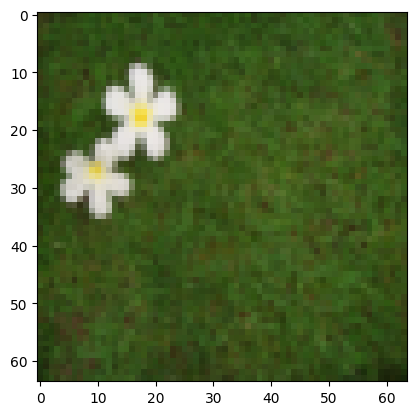

In [ ]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

# Example of a picture
index = 6
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [ ]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px_height = train_set_x_orig.shape[1]
num_px_width = train_set_x_orig.shape[2]
num_px = num_px_width

print ("Cantidad de muestras de train: m_train = " + str(m_train))
print ("Cantidad de muestras de test:  m_test = " + str(m_test))
print ("Altura de las imágenes: num_px_height = " + str(num_px_height))
print ("Anchura de las imágenes: num_px_width = " + str(num_px_width))
print ("Tamaño de cada imagen: (" + str(num_px_height) + ", " + str(num_px_width) + ", 3)")
print ("Estructura de las muestras de train X: " + str(train_set_x_orig.shape))
print ("Estructura de las etiquetas de train Y: " + str(train_set_y.shape))
print ("Estructura de las muestras de test X: " + str(test_set_x_orig.shape))
print ("Estructura de las etiquetas de test Y: " + str(test_set_y.shape))

# Vamos a reestructurar los datos, convirtiendo el cubo que forma una imagen [height, width, channels] a un vector de height*width*channel elementos
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T


print ("X_train.shape: " + str(train_set_x_flatten.shape))
print ("Y_train.shape: " + str(train_set_y.shape))
print ("X_test.shape: " + str(test_set_x_flatten.shape))
print ("Y_test.shape: " + str(test_set_y.shape))

print ("Verifica que los datos se han reestructurado correctamente: " + str(train_set_x_flatten[0:5,0]))

# Para estandarizar los datos, dividiremos el valor de cada pixel por el valor maximo (255 en este caso).
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

Cantidad de muestras de train: m_train = 209
Cantidad de muestras de test:  m_test = 50
Altura de las imágenes: num_px_height = 64
Anchura de las imágenes: num_px_width = 64
Tamaño de cada imagen: (64, 64, 3)
Estructura de las muestras de train X: (209, 64, 64, 3)
Estructura de las etiquetas de train Y: (1, 209)
Estructura de las muestras de test X: (50, 64, 64, 3)
Estructura de las etiquetas de test Y: (1, 50)
X_train.shape: (12288, 209)
Y_train.shape: (1, 209)
X_test.shape: (12288, 50)
Y_test.shape: (1, 50)
Verifica que los datos se han reestructurado correctamente: [17 31 56 22 33]


# Construyendo el algoritmo
Para entrenar una red neuronal, tenemos que implementar las siguientes líneas:


1.   Definir la estructura del modelo (¿cuántas varaibles de entrada?).
2.   Inicializar los parámetros del modelo.
3.   Loop:
   *   Calcular el valor de la función de coste (forward pass).
   *   Calcular el valor de los gradientes (backward pass).
   *   Actualizar los parámetros (gradient descent).

A continuación, vamos a implementar cada parte de forma separada para juntar todas al final, implementando una red neuronal.

## 2.1 Funciones ayudantes
Implementa la función sigmoid() ($\sigma$). Más adelante la necesitaremos, para calcular las predicciones $\sigma(W^T x+ b)$. Recuerda que $\sigma(z) = \frac{1}{1+e^{-z}}$

In [ ]:
# sigmoid funtzioa
import math
def sigmoid(z):
    """
    Calcula el sigmoide de z

    Input:
    z -- Un número real o un numpy-array de números reales.

    Output:
    s -- sigmoid(z)
    """
    ## PON TU CODIGO AQUI ## (≈ 2 lineas)
    s = 1 / (1 + np.exp(-z))
    return s


print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


## 2.2 Inicializar los parámetros
**Ejercicio:** Tienes que inicializar los parámetros en el siguiente código. Para eso, crea el array $w$ con ceros. **Pista:** mira la función np.zeros().

In [ ]:
def initialize_with_zeros(dim):
    """
    Esta funcion crea un vector de ceros de dimensiones (dim, 1), para inicializar w y b.

    Argument:
    dim -- tamaño del vector w.

    Returns:
    w -- vector w de ceros con dimension (dim, 1).
    b -- parametro b inicializado a 0.
    """

    ## PON TU CODIGO AQUI ## (≈ 2 lineas)


    w = np.zeros((dim,1))
    b = 0

    ######################
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b


dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


Gure datuak irudiak direnean,  $w$  (num_px  ×  num_px  ×  3, 1) dimentsioko bektorea izango da.

# 2.3 Forward y backward pass
Una vez inicializados los parámetros del modelo, dado un dataset de train, tenemos que implementar las funciones forward y backward que nos permitan aprender los parámetros.

**Ejercicio:** Implementa la función de coste y su gradiente en la función propagate().

**Pistas:**

Forward pass:


*   Consigue $X$.
*   Calcula $A = \sigma (W^T X + b) = (a^{(1)}, a^{(2)}, \ldots, a^{(m)}) $
*   Calcula la función de coste $J = -\frac{1}{m}\Sigma_{i=1}^m y^{(i)} log(a^(i)) + (1-y^{(i)}) log(1-a^{(i)})$

Backward pass:


*   $\frac{\delta J}{\delta w} = \frac{1}{m} X (A-Y)^T$
*   $\frac{\delta J}{\delta b} = \frac{1}{m} \Sigma_{i=1}^m (a^{(i)}-y^{(i)})$

In [ ]:
def propagate(w, b, X, Y):
    import math
    """
    Calcula la funcion de coste y su gradiente ejecutando el forward y el backward pass.

    Input:
    w -- pesos, numpy-array de tamaño (num_px * num_px * 3, 1).
    b -- parametro b (bias).
    X -- Conjunto de muestras X de train. Dimension: (num_px * num_px * 3, number of examples)
    Y -- Conjunto de etiquetas Y de train (0 -> no gato, 1 -> gato). Dimension: (1, number of examples)

    Output:
    cost -- Coste de la regresion logistica.
    dw -- gradiente de la funcion de coste respecto a w.
    db -- gradiente de la funcion de coste respecto a b.

    Pista:
    - Escribe tu codigo paso a paso para la propagacion. np.log(), np.dot()
    """

    m = X.shape[1]

    # FORWARD PASS (empezando desde X hasta calcular el coste)
    ## PON TU CODIGO AQUI ##  (≈ 2 lineas de codigo)
    A = sigmoid(np.dot(w.T, X) + b)  # Activación
    J = -1/m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))

    ######################

    # BACKWARD PASS (calcula el gradiente)
    ## PON TU CODIGO AQUI ## (≈ 3 lineas de codigo)

    dz = A - Y
    dw = np.dot(X, dz.T) / m
    db = np.sum(dz) / m
    ######################

    # Asegúrate de que dw y db son de la forma correcta
    assert(dw.shape == w.shape)
    assert(db.dtype == float)

    cost = J  # coste es el resultado de la forward pass

    gradients = {"dw": dw,
                 "db": db}

    return gradients, cost


w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


## 2.4 Gradient descent
En este punto ya:


*   has inicializado los parámetros,
*   eres capaz de calcular la función de coste y el gradiente,
*   vas a actualizar los parámetros usando el algoritmo "gradient descent" (descenso de gradiente)

**Ejercicio:** implementa el algoritmo de descenso de gradiente en la función optimize(). Recuerda que el objetivo es aprender los parámetros $w$ y $b$ que minimicen la función $J$. Para cualquier parámetro $\theta$, éste se actualiza segun la regla $\theta = \theta - \alpha \delta \theta$, donde $\alpha$ es la tasa de aprendizaje (learning rate).

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    Esta función optimiza los parámetros w y b para minimizar la función de coste siguiendo
    el algoritmo de gradient descent.

    Input:
    w -- pesos, numpy-array de tamaño (num_px * num_px * 3, 1).
    b -- parámetro b (bias).
    X -- Conjunto de muestras X de train. Dimension: (num_px * num_px * 3, number of examples)
    Y -- Conjunto de etiquetas Y de train (0 -> no gato, 1 -> gato). Dimension: (1, number of examples)
    num_iterations -- numero de iteraciones del algoritmo.
    learning_rate -- tasa de aprendizaje de la regla de actualización.
    print_cost -- cuando es True, imprime el valor del gradiente cada 100 iteraciones.

    Output:
    params -- diccionario que guarda los parametros w y b.
    grads -- diccionario que guarda los gradientes de los parametros w y b respecto a la funcion de coste.
    costs -- lista donde se guardan los valores de coste. Los usaremos para generar una grafica.

    Pistas:
    Tienes que implementar dos pasos e iterar sobre ellos:
        1) Calcular el coste y el gradiente para los parametros actuales. Usa propagate()
        2) Actualizar los parametros w y b utilizando la regla de actualizacion del descenso de gradiente .
    """

    costs = []
    params = {'w':w,
             'b':b}
    m = X.shape[1]

    for i in range(num_iterations):

        # Calculo del coste y del gradiente (≈ 1 linea de codigo)
        ## PON TU CODIGO AQUI ##
        grads, cost = propagate(w, b, X, Y)

        ######################

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        ## PON TU CODIGO AQUI ## #regla de actualizacion (≈ 3 lineas de codigo)

        ######################
        w = w - learning_rate * dw
        b = b - learning_rate * db
        # Guarda los costes.
        if i % 100 == 0:
            costs.append(cost)

        # Imprime el coste cada 100 iteraciones.
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))


w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


**Ejercicio:** La función anterior calcula los parámetros $w$ y $b$. La última función que necesitamos es la función predict(). Esta función será capaz de predecir la clase de unas muestras de test $X$, dados los parámetros $w$ y $b$. Para ello, tenemios que dar dos pasos:


1.   Calcula $\hat{y} = A = \sigma (W^T X + b)$.
2.   Convierte la predicción a 0 (si $\hat{y} < 0.5$) o a 1 (si $\hat{y} \geq 0.5)$. Guarda todas las predicciones en el array Y_prediction.

In [ ]:
def predict(w, b, X):
    '''
    Dados los parametros de la regresion logistica (w, b), predice las clases (0 o 1) de las muestras.

    Input:
    w -- pesos, numpy-array de tamaño (num_px * num_px * 3, 1).
    b -- parametro b (bias)).
    X -- Conjunto de muestras X de test. Dimension: (num_px * num_px * 3, number of examples)

    Output:
    Y_prediction -- numpy-array con todas las predicciones obtenidas para las muestras en X (0/1).
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)

    # Calcula el vector "A", donde tendremos las probabilidades de que cada foto contenga un gato.
    ## PON TU CODIGO AQUI ##  (≈ 1 linea)

    ######################
    A = sigmoid(np.dot(w.T, X) + b)
    for i in range(A.shape[1]):
        # Convierte las probabilidades A[0, i] a predicciones (0/1)
        ## PON TU CODIGO AQUI ## (≈ 2 lineas)

        ######################
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0

    assert(Y_prediction.shape == (1, m))

    return Y_prediction


w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predicciones = " + str(predict(w, b, X)))


predicciones = [[1. 1. 0.]]


# Construye el modelo y el clasificador
Ya tenemos todos los ingredientes. Ahora usaremos todas las funciones anteriores para aplicar un clasificador de regresión logística a nuestro dataset.

**Ejercicio:** Implementa el modelo usanod las funciones anteriores. Utiliza los siguientes nombres para declarar las variables:


*   Y_prediction_test: predicciones hechas sobre el dataset de test.
*   Y_prediction_train: predicciones hechas sobre el dataset de train.

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %
y = 0, you predicted that it is a "non-cat" picture.


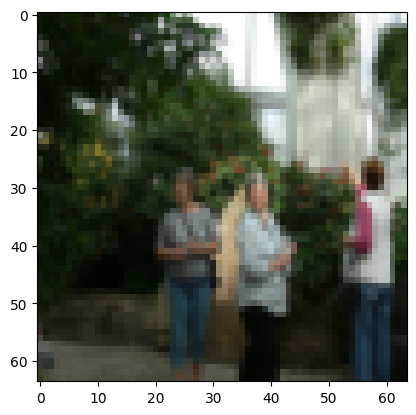

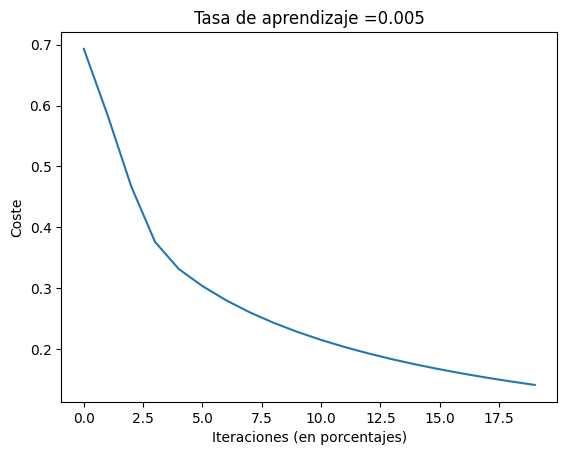

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Implementa el modelo de regresion logisitca usando las funciones implementadas anteriormente.

    Input:
    X_train -- numpy-array con el conjunto de muestras X de train. Dimension: (num_px * num_px * 3, m_train)
    Y_train -- numpy-array con el conjunto de etiquetas Y de train (0 -> no gato, 1 -> gato). Dimension: (1, m_train)
    X_test -- numpy-array con el conjunto de muestras X de test. Dimension: (num_px * num_px * 3, m_test)
    Y_test -- numpy-array con el conjunto de etiquetas Y de test (0 -> no gato, 1 -> gato). Dimension: (1, m_test)
    num_iterations -- Numero de iteraciones del algoritmo de gradient descent.
    learning_rate -- hyperparametro que representa la tasa de aprendizaje (learning rate) de la regla de actualizacion en la función optimize().
    print_cost -- True para imprimir el coste cada 100 iteraciones.

    Output:
    d -- diccionario con la informacion sobre el modelo (coste, predicciones de tes, predicciones de train, w, b, tasa de aprendizaje y numero de iteraciones).
    """

    ## PON TU CODIGO AQUI ##

    # Inicializa los parametros a 0 (≈ 1 linea)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 linea)
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)


    # Extrae los parametros w y b
    w = params["w"]
    b = params["b"]


    # Predice las clases para las muestras de train y de test (≈ 2 lineas)
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)


    #####################

    # Imprime la metrica de accuracy tanto para train como para test.
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"cost": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "lr" : learning_rate,
         "iterations": num_iterations}

    return d


d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

# Vamos a imprimir un ejemplo.
index = 21
plt.figure(1)
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))

print ("y = " + str(test_set_y[0,index])+ ", you predicted that it is a \"" + classes[test_set_y[0,index]].decode("utf-8") +  "\" picture.")

# Imprime la grafica del coste (curva de aprendizaje)
costs = np.squeeze(d['cost'])
plt.figure(2)
plt.plot(costs)
plt.ylabel('Coste')
plt.xlabel('Iteraciones (en porcentajes)')
plt.title("Tasa de aprendizaje =" + str(d["lr"]))
plt.show()